# credit-default-risk-prediction

This project fits multiple classification models to the data and figures out the best model. This model is then used to predict the probability of a borrower to deafult credit and miss payments. 

This can be used by banks to approve or disaaprove loans based on the probability of the borrower defaulting. 

The data used in this project is from Kaggle and can be found here: https://www.kaggle.com/c/GiveMeSomeCredit/overview

![](https://daxg39y63pxwu.cloudfront.net/hackerday_banner/hq/loan-default-risk-prediction-machine-learning-project.jpg)

**Table of contents:**

    1. Download and prepare the dataset from kaggle. 
    2. Preprocessing (Imputer, MinMaxScaler, Training and Validation set). 
    3. Fit the data to a Linear regression, Decision forest, random forest, and a GBM. 
    4. Make predictions and evaluate the outputs for accuracy. 
    5. Save the best model. 

In [ ]:
!pip install opendatasets pandas xgboost numpy matplotlib scikit-learn

In [ ]:
import os
import opendatasets as od
import pandas as pd
import plotly.express as px

In [13]:
od.download('https://www.kaggle.com/c/GiveMeSomeCredit/overview')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Your Kaggle Key: ··········


100%|██████████| 5.16M/5.16M [00:00<00:00, 86.6MB/s]


Extracting archive ./GiveMeSomeCredit/GiveMeSomeCredit.zip to ./GiveMeSomeCredit


In [15]:
dir = os.listdir('GiveMeSomeCredit')

In [16]:
train_df = pd.read_csv('./GiveMeSomeCredit/cs-training.csv')
test_df = pd.read_csv('./GiveMeSomeCredit/cs-test.csv')
submission_df = pd.read_csv('./GiveMeSomeCredit/sampleEntry.csv')


In [17]:
train_df

Unnamed: 0  ...  NumberOfDependents
0                1  ...                 2.0
1                2  ...                 1.0
2                3  ...                 0.0
3                4  ...                 0.0
4                5  ...                 0.0
...            ...  ...                 ...
149995      149996  ...                 0.0
149996      149997  ...                 2.0
149997      149998  ...                 0.0
149998      149999  ...                 0.0
149999      150000  ...                 0.0

[150000 rows x 12 columns]

In [ ]:
train_df.describe()

Unnamed: 0  ...  NumberOfDependents
count  150000.000000  ...       146076.000000
mean    75000.500000  ...            0.757222
std     43301.414527  ...            1.115086
min         1.000000  ...            0.000000
25%     37500.750000  ...            0.000000
50%     75000.500000  ...            0.000000
75%    112500.250000  ...            1.000000
max    150000.000000  ...           20.000000

[8 rows x 12 columns]

In [18]:
fig = px.histogram(train_df, x='age', marginal='box', color_discrete_sequence=['red'], nbins=47, title='Distribution of age')
fig.update_layout(bargap=0.1)
fig.show()

The mean age in this dataset is around 52. With a couple of outliers. The lowest age is 0 which should be impossible. This is most likely a mistake. 

In [ ]:
fig = px.histogram(train_df, x='MonthlyIncome', marginal='box', nbins=47, title='Distribution of MonthlyIncome')
fig.update_layout(bargap=0.1)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

According to the graph most of the borrowers in the graph are in the $0 - $100k range and there is one person who makes $3m which is a massive outlier. 

In [ ]:
fig = px.histogram(train_df, x='NumberOfDependents', marginal='box', nbins=47, title='Distribution of Dependents')
fig.update_layout(bargap=0.1)
fig.show()

The majority of the borrowers have 0 dependents. With one have 20 dependents which is another massive outlier. This is most likely the same person who also makes $3M. 

In [ ]:
fig = px.histogram(train_df, x='NumberOfOpenCreditLinesAndLoans', marginal='box', color_discrete_sequence=['red'] ,nbins=47, title='Distribution of Credit Lines and Loans')
fig.update_layout(bargap=0.1)
fig.show()

Our borrowers have an average of 8 open credit lines and loans. This chart also has many outliers with the highest borrower having 58 open credit lines and loans. 

##Processing the data
This section divides the data into input and target columns. 

Imputing the nan values in the data. 

In [22]:
import seaborn as sns

In [23]:
import numpy as np

In [24]:
target_cols = ['SeriousDlqin2yrs']

In [25]:
input_cols = ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']

In [26]:
input = train_df[input_cols].copy()
targets = train_df[target_cols].copy()

In [27]:
test_inputs = test_df[input_cols].copy()

In [28]:
numeric_cols = input.select_dtypes(include=np.number).columns.tolist()

In [29]:
numeric_cols

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

In [30]:
train_df[input_cols]

RevolvingUtilizationOfUnsecuredLines  ...  NumberOfDependents
0                                   0.766127  ...                 2.0
1                                   0.957151  ...                 1.0
2                                   0.658180  ...                 0.0
3                                   0.233810  ...                 0.0
4                                   0.907239  ...                 0.0
...                                      ...  ...                 ...
149995                              0.040674  ...                 0.0
149996                              0.299745  ...                 2.0
149997                              0.246044  ...                 0.0
149998                              0.000000  ...                 0.0
149999                              0.850283  ...                 0.0

[150000 rows x 10 columns]

# Imputing the null values
The only 2 variables that have null values are the Monthly Income and the NumberOfDependents. 

1.   It's safe to assume that most of the empty NumberOfDependents fields equal to 0 since they left it blank while filling the form. 
2.   I will take the mean of the overall monthly income and then impute it to the missing Monthly Income field. This will help us use the average income as an assumption of the actual income of these borrowers. 



In [31]:
input.isna().sum()

RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [32]:
targets.isna().sum()

SeriousDlqin2yrs    0
dtype: int64

In [33]:
min_dependents = input.NumberOfDependents.min()

In [34]:
min_dependents

0.0

In [35]:
input['NumberOfDependents'].fillna(min_dependents, inplace=True)
test_inputs['NumberOfDependents'].fillna(min_dependents, inplace=True)

In [36]:
from sklearn.impute import SimpleImputer

In [37]:
imputer = SimpleImputer(strategy = 'mean')

In [38]:
imputer.fit(input[numeric_cols])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [39]:
input[numeric_cols] = imputer.transform(input[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [40]:
input[numeric_cols].isna().sum()

RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

# Scaling the data 

In this part of the project I use the MinMaxScaler to transform the existing data and scale it to a number between 1 and 0 to give all fields an equal weight. This helps reduce the skew caused by the outliers in the data. 

In [41]:
from sklearn.preprocessing import MinMaxScaler

In [42]:
scaler = MinMaxScaler()

In [43]:
scaler.fit(input[numeric_cols])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [44]:
input[numeric_cols] = scaler.transform(input[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [45]:
input

RevolvingUtilizationOfUnsecuredLines  ...  NumberOfDependents
0                               1.510859e-05  ...                0.10
1                               1.887574e-05  ...                0.05
2                               1.297981e-05  ...                0.00
3                               4.610905e-06  ...                0.00
4                               1.789145e-05  ...                0.00
...                                      ...  ...                 ...
149995                          8.021193e-07  ...                0.00
149996                          5.911200e-06  ...                0.10
149997                          4.852172e-06  ...                0.00
149998                          0.000000e+00  ...                0.00
149999                          1.676822e-05  ...                0.00

[150000 rows x 10 columns]

# Training and Validation set
In this section I will use the train_test_split function to divide 20% of our train_df dataframe into a validation set. Later when I fit the data to the training set I can use the validation set to check how well our model works. 

In [47]:
import matplotlib.pyplot as plt

In [48]:
input

RevolvingUtilizationOfUnsecuredLines  ...  NumberOfDependents
0                               1.510859e-05  ...                0.10
1                               1.887574e-05  ...                0.05
2                               1.297981e-05  ...                0.00
3                               4.610905e-06  ...                0.00
4                               1.789145e-05  ...                0.00
...                                      ...  ...                 ...
149995                          8.021193e-07  ...                0.00
149996                          5.911200e-06  ...                0.10
149997                          4.852172e-06  ...                0.00
149998                          0.000000e+00  ...                0.00
149999                          1.676822e-05  ...                0.00

[150000 rows x 10 columns]

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(input,
                                                                        targets,
                                                                        test_size=0.2,
                                                                        random_state=42
                                                                        )

In [51]:
train_inputs

RevolvingUtilizationOfUnsecuredLines  ...  NumberOfDependents
104025                              0.000000  ...                0.00
5415                                0.000012  ...                0.00
75612                               0.000000  ...                0.20
138169                              0.000008  ...                0.25
87184                               0.000000  ...                0.00
...                                      ...  ...                 ...
119879                              0.000002  ...                0.05
103694                              0.000002  ...                0.05
131932                              0.000001  ...                0.00
146867                              0.000004  ...                0.00
121958                              0.000004  ...                0.00

[120000 rows x 10 columns]

In [52]:
train_targets

SeriousDlqin2yrs
104025                 0
5415                   0
75612                  0
138169                 0
87184                  0
...                  ...
119879                 0
103694                 0
131932                 0
146867                 0
121958                 0

[120000 rows x 1 columns]

# Linear fit model
In this section of the model I will fit a Logistic Regression to the training data and check the fit with the validation data. 

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
regression = LogisticRegression()

In [ ]:
regression.fit(train_inputs, train_targets)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
weight_df = pd.DataFrame({
    'feature': (numeric_cols),
    'weight': regression.coef_.tolist()[0]
})

In [ ]:
weight_df.sort_values('weight', ascending=False)

feature     weight
2  NumberOfTime30-59DaysPastDueNotWorse  12.163444
6               NumberOfTimes90DaysLate   4.759034
9                    NumberOfDependents   1.801836
7          NumberRealEstateLoansOrLines   0.660304
0  RevolvingUtilizationOfUnsecuredLines  -0.236424
5       NumberOfOpenCreditLinesAndLoans  -0.294747
3                             DebtRatio  -0.372178
4                         MonthlyIncome  -1.548558
1                                   age  -3.367620
8  NumberOfTime60-89DaysPastDueNotWorse -13.615356

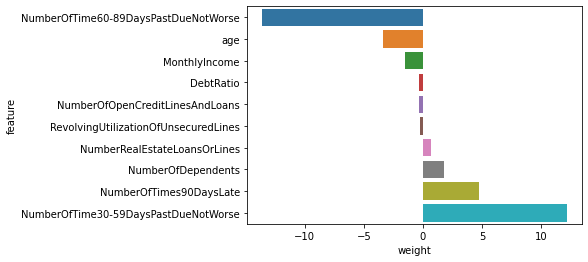

In [ ]:
sns.barplot(data=weight_df.sort_values('weight', ascending = 'false').head(10), x='weight', y='feature')

In [ ]:
regression_preds = regression.predict(train_inputs)

In [ ]:
regression_preds

array([0, 0, 0, ..., 0, 0, 0])

In [60]:
from sklearn.metrics import mean_squared_error

In [58]:
def rmse(targets, preds):
  error = mean_squared_error(targets, preds, squared=False)
  return error

In [ ]:
rmse(train_targets, regression_preds)

0.2589562382591571

In [ ]:
regression_val_preds = regression.predict(val_inputs)

In [ ]:
rmse(val_targets, regression_val_preds)

0.25521232990067966

In [ ]:
test_proba = regression.predict(test_inputs)

In [ ]:
submission_df['Probability'] = test_proba

In [ ]:
submission_df

Id  Probability
0            1            0
1            2            0
2            3            0
3            4            0
4            5            0
...        ...          ...
101498  101499            0
101499  101500            0
101500  101501            0
101501  101502            0
101502  101503            0

[101503 rows x 2 columns]

In [ ]:
submission_df.to_csv('Submission.csv', index=None)

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink('Submission.csv')

/content/Submission.csv

## Decisions Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tree = DecisionTreeClassifier(random_state=42)

In [ ]:
tree.fit(train_inputs, train_targets)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
tree_preds = tree.predict(train_inputs)

In [ ]:
rmse(train_targets, tree_preds)

0.019364916731037084

In [ ]:
tree_val_preds = tree.predict(val_inputs)

In [ ]:
rmse(val_targets, tree_val_preds)

0.32114378918692066

Even though the training model has a lower RMSE the validation model has a higher RMSE compared to the regression fit. This shows that overfitting is occuring in the decision tree. 

In [ ]:
tree_proba = tree.predict(test_inputs)

In [ ]:
submission_df['Probability'] = tree_proba

In [ ]:
submission_df.to_csv('Submission.csv', index=None)

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink('Submission.csv')

/content/Submission.csv

# Random Forests
In this section I will the fit the data to Decision Trees and Random forests. I will ultimately tune the data to find the best fit and the lowest RMSE value. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
random_tree = RandomForestClassifier(random_state=42, n_jobs=-1)

In [ ]:
random_tree.fit(train_inputs, train_targets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
random_preds = random_tree.predict(train_inputs)

In [ ]:
rmse(train_targets, random_preds)

0.03685557397915997

In [ ]:
random_val_preds = random_tree.predict(val_inputs)

In [ ]:
rmse(val_targets, random_val_preds)

0.2516611478423583

The training RMSE is extremely low compare to the validation RMSE most likely due to overfitting to the training data. To counter this overfitting we will now tune the parameters of the random forest model. 

In [ ]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
    train_rmse = rmse(model.predict(train_inputs), train_targets)
    val_rmse = rmse(model.predict(val_inputs), val_targets)
    return train_rmse, val_rmse

In [ ]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed

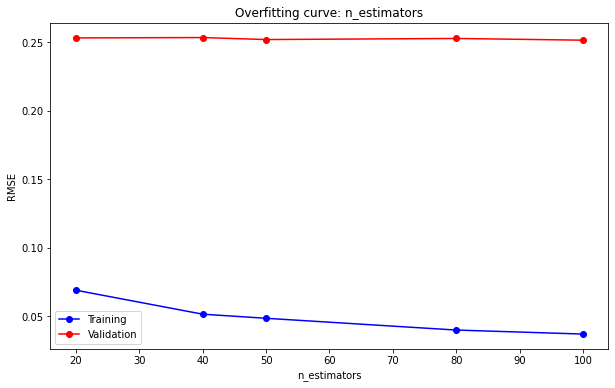

In [ ]:
test_param_and_plot('n_estimators', [20, 40, 50, 80, 100])

20 estimators are ideal since there is not much loss in the RMSE when we increase the numebr of estimators. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed

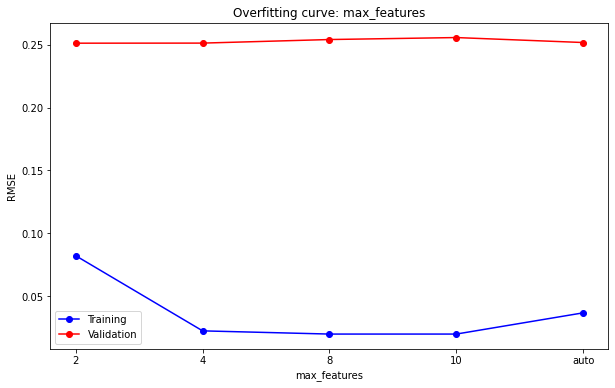

In [ ]:
test_param_and_plot('max_features', [2, 4, 8, 10, 'auto'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



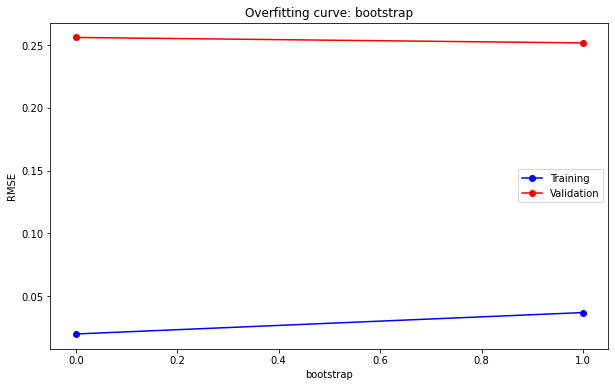

In [ ]:
test_param_and_plot('bootstrap', [True,False])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed

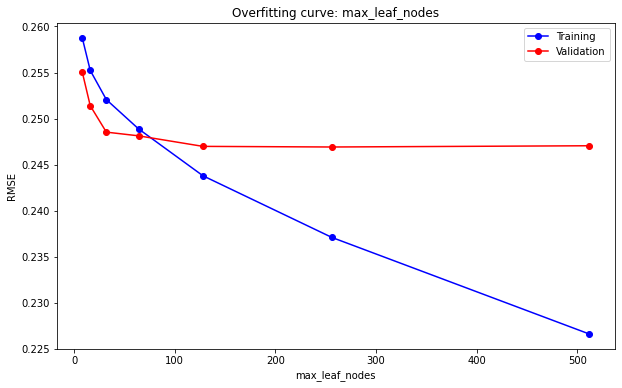

In [ ]:
test_param_and_plot('max_leaf_nodes', [8, 16, 32, 64, 128, 256, 2**9])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed

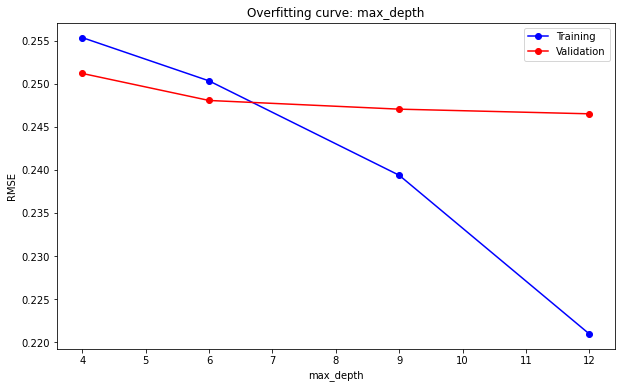

In [ ]:
test_param_and_plot('max_depth', [None, 4, 6,9, 12, ])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



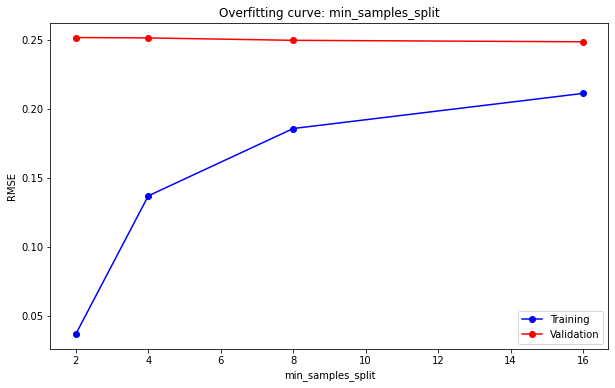

In [ ]:
test_param_and_plot('min_samples_split', [2,4,8,16])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



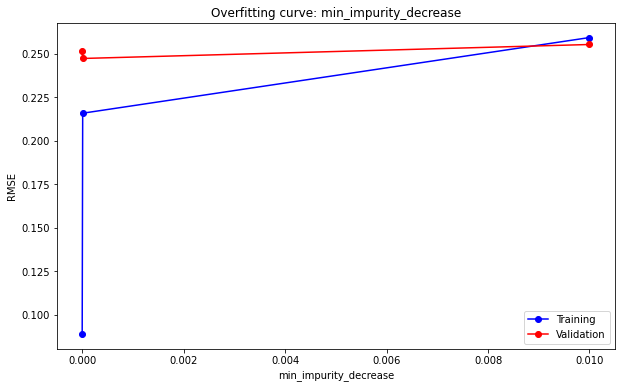

In [ ]:
test_param_and_plot('min_impurity_decrease', [1e-7,1e-5,1e-2])

In [ ]:
random_tuned_tree = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=40, max_leaf_nodes=256)

In [ ]:
random_tuned_tree.fit(train_inputs, train_targets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=256, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
random_tuned_preds = random_tuned_tree.predict(train_inputs)

In [ ]:
rmse(train_targets, random_tuned_preds)

0.23710054126185934

In [ ]:
random_tuned_val_preds = random_tuned_tree.predict(val_inputs)

In [ ]:
rmse(val_targets, random_tuned_val_preds)

0.2477229635432829

In [ ]:
weight_df = pd.DataFrame({
    'feature': (numeric_cols),
    'weight': random_tuned_tree.feature_importances_.tolist()[0]
})

In [ ]:
weight_df.sort_values('weight', ascending=False)

feature    weight
0  RevolvingUtilizationOfUnsecuredLines  0.093645
1                                   age  0.093645
2  NumberOfTime30-59DaysPastDueNotWorse  0.093645
3                             DebtRatio  0.093645
4                         MonthlyIncome  0.093645
5       NumberOfOpenCreditLinesAndLoans  0.093645
6               NumberOfTimes90DaysLate  0.093645
7          NumberRealEstateLoansOrLines  0.093645
8  NumberOfTime60-89DaysPastDueNotWorse  0.093645
9                    NumberOfDependents  0.093645

In [ ]:
random_test_preds = random_tuned_tree.predict(test_inputs)

In [ ]:
submission_df['Probability'] = 1 - random_test_preds

In [ ]:
submission_df.to_csv('RandomForest.csv', index=None)

In [ ]:
FileLink('RandomForest.csv')

/content/RandomForest.csv

# XGBoosting
In this section I will fit the data to an Extreme Gradient Boosting Model and then tune the model to find the lowest RMSE and the best fit for the data. 

In [53]:
from xgboost import XGBClassifier

In [54]:
xgb = XGBClassifier(random_state=42, n_jobs=-1)

In [55]:
xgb.fit(train_inputs, train_targets)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [56]:
xgb_preds = xgb.predict(train_inputs)

In [61]:
rmse(xgb_preds, train_targets)

0.24898125766142853

In [62]:
xgb_val_preds = xgb.predict(val_inputs)

In [63]:
rmse(xgb_val_preds, val_targets)

0.2469817807045694

In [64]:
xgb_test_preds = xgb.predict_proba(test_inputs)

In [ ]:
submission_df['Probability'] = 1- xgb_test_preds

In [ ]:
submission_df

Id  Probability
0            1     0.079207
1            2     0.045756
2            3     0.013551
3            4     0.081263
4            5     0.099263
...        ...          ...
101498  101499     0.030656
101499  101500     0.314006
101500  101501     0.007076
101501  101502     0.069585
101502  101503     0.042200

[101503 rows x 2 columns]

In [ ]:
submission_df.to_csv('XGBPreds.csv', index=None)

In [ ]:
FileLink('XGBPreds.csv')

/content/XGBPreds.csv

In [ ]:
def test_xgb_params(**params):
  model = XGBClassifier(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
  train_rmse = rmse(model.predict(train_inputs), train_targets)
  val_rmse = rmse(model.predict(val_inputs), val_targets)
  return train_rmse, val_rmse

In [ ]:
def test_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_xgb_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_la

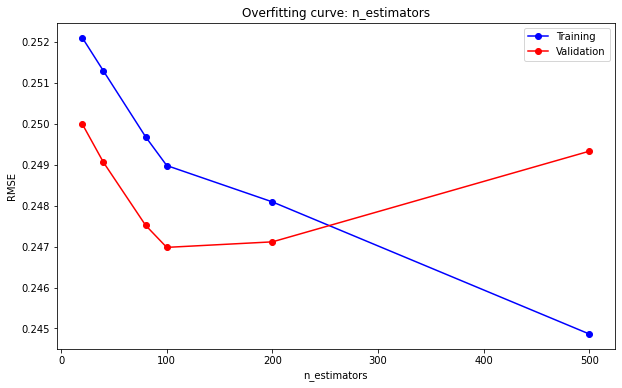

In [ ]:
test_and_plot('n_estimators', [20, 40, 80, 100, 200, 500])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_la

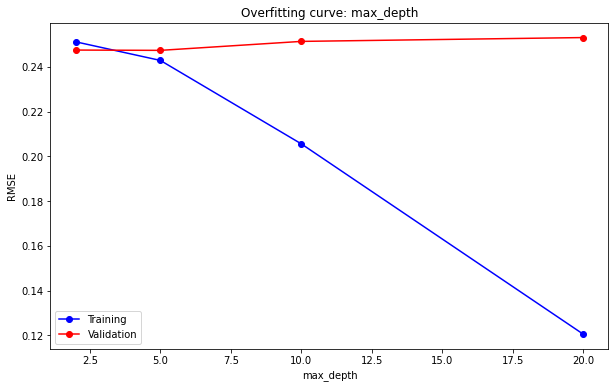

In [ ]:
test_and_plot('max_depth', [2, 5, 10, 20])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_la

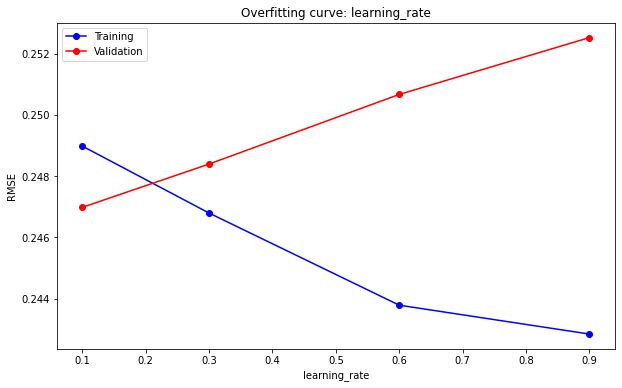

In [ ]:
test_and_plot('learning_rate', [0.1, 0.3, 0.6, 0.9])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_la

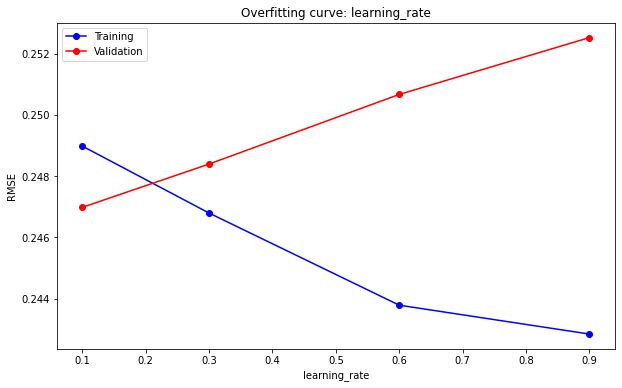

In [ ]:
test_and_plot('learning_rate', [0.1, 0.3, 0.6, 0.9])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_la

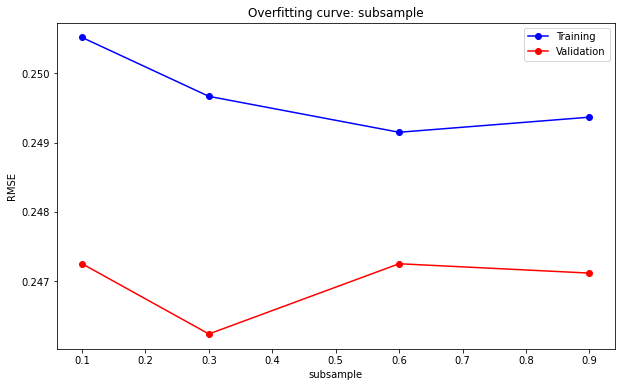

In [ ]:
test_and_plot('subsample', [ 0.1, 0.3, 0.6, 0.9])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_la

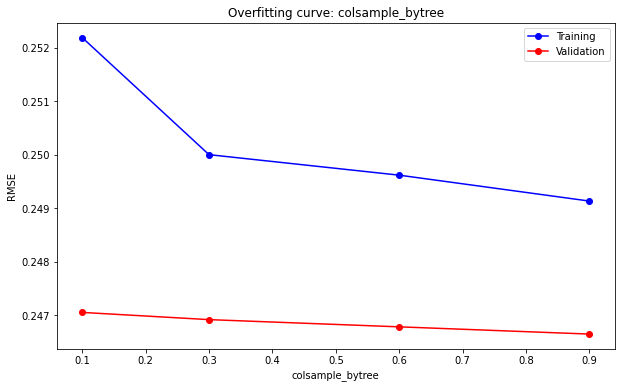

In [ ]:
test_and_plot('colsample_bytree', [ 0.1, 0.3, 0.6, 0.9])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_la

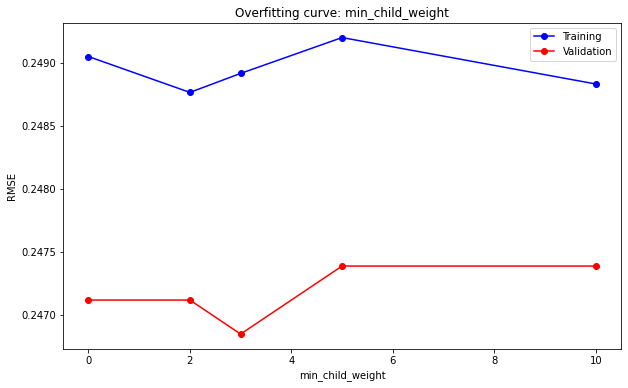

In [ ]:
test_and_plot('min_child_weight', [0, 2, 3, 5, 10])

In [66]:
xgb_tuned = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=120, subsample=0.3, colsample_bytree=0.3)

In [67]:
xgb_tuned.fit(train_inputs, train_targets)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=120, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.3, verbosity=1)

In [68]:
xgb_tuned_preds = xgb_tuned.predict_proba(test_inputs)

In [70]:
weights_df = xgb_tuned.feature_importances_

In [76]:
weights_df

array([0.15420829, 0.04690889, 0.17580678, 0.02736484, 0.02179497,
       0.02988567, 0.32957458, 0.02681831, 0.17461352, 0.01302414],
      dtype=float32)

In [ ]:
submission_df['Probability'] = 1- xgb_tuned_preds

In [ ]:
submission_df

Id  Probability
0            1     0.064455
1            2     0.044840
2            3     0.018045
3            4     0.089042
4            5     0.080671
...        ...          ...
101498  101499     0.035913
101499  101500     0.333059
101500  101501     0.006005
101501  101502     0.076173
101502  101503     0.047694

[101503 rows x 2 columns]

In [ ]:
submission_df.to_csv('XGBClassifier', index=None)

In [ ]:
FileLink('XGBClassifier')

/content/XGBClassifier

#Conclusion and Submission



In [82]:
def predict_input(single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    X_input = input_df[numeric_cols]
    pred = xgb_tuned.predict(X_input)[0]
    prob = xgb_tuned.predict_proba(X_input)[0][list(xgb_tuned.classes_).index(pred)]
    return pred, prob

new_input = {'RevolvingUtilizationOfUnsecuredLines': 0.76,
             'age': 45 ,
             'NumberOfTime30-59DaysPastDueNotWorse': 2,
             'DebtRatio': .80,
             'MonthlyIncome': 9120,
             'NumberOfOpenCreditLinesAndLoans': 13,
             'NumberOfTimes90DaysLate': 0,
             'NumberRealEstateLoansOrLines': 6,
             'NumberOfTime60-89DaysPastDueNotWorse': 0,
             'NumberOfDependents': 2,}
           
predict_input(new_input)

(0, 0.61561096)

In [89]:
numeric_cols

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

In [83]:
xgb_tuned.feature_importances_

array([0.15420829, 0.04690889, 0.17580678, 0.02736484, 0.02179497,
       0.02988567, 0.32957458, 0.02681831, 0.17461352, 0.01302414],
      dtype=float32)

In [92]:
pd.DataFrame(xgb_tuned.feature_importances_, numeric_cols)

0
RevolvingUtilizationOfUnsecuredLines  0.154208
age                                   0.046909
NumberOfTime30-59DaysPastDueNotWorse  0.175807
DebtRatio                             0.027365
MonthlyIncome                         0.021795
NumberOfOpenCreditLinesAndLoans       0.029886
NumberOfTimes90DaysLate               0.329575
NumberRealEstateLoansOrLines          0.026818
NumberOfTime60-89DaysPastDueNotWorse  0.174614
NumberOfDependents                    0.013024

In [93]:
!pip install jovian --upgrade --quiet

In [94]:
import jovian

In [95]:
# Execute this to save new versions of the notebook
jovian.commit(project="credit-default-risk-prediction")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/siddharthkatta123/credit-default-risk-prediction


'https://jovian.ai/siddharthkatta123/credit-default-risk-prediction'

In [ ]:
jovian.submit(assignment="zerotogbms-project")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/siddharthkatta123/credit-default-risk-prediction
[jovian] Submitting assignment..
[jovian] Verify your submission at https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms/assignment/course-project-real-world-machine-learning-model


In Conclustion the tuned XGBClassifier was the best model which got me the lowest RMSE value and the highest score on kaggle at .86551